# Выбор локации для скважины

Добывающей компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загружаю необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Загружаю файлы

In [2]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_0.info()
print(geo_0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


In [4]:
geo_1.info()
print(geo_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305


In [5]:
geo_2.info()
print(geo_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


Мы имеем три идентичных по структуре датасета (100000 строк и 5 колонок), ID нам не понадобится, удаляю. Пропущенных данных нет.

In [6]:
geo_0 = geo_0.drop(['id'], axis=1)
geo_1 = geo_1.drop(['id'], axis=1)
geo_2 = geo_2.drop(['id'], axis=1)

Посмотрим на целевой признак с помощью диаграммы размаха.

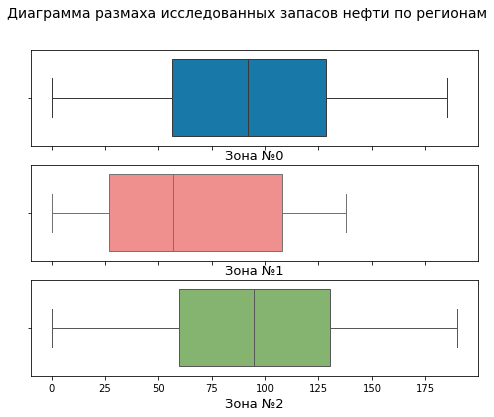

In [7]:
f, ax = plt.subplots(3,1, figsize=(8,6), sharex=True)
sns.boxplot(geo_0['product'], palette="winter", linewidth=1, ax=ax[0])
sns.boxplot(geo_1['product'], palette="spring", linewidth=1, ax=ax[1])
sns.boxplot(geo_2['product'], palette="summer", linewidth=1, ax=ax[2])
plt.suptitle('Диаграмма размаха исследованных запасов нефти по регионам', size=14)
ax[0].set_xlabel('Зона №0', size=13)
ax[1].set_xlabel('Зона №1', size=13)
ax[2].set_xlabel('Зона №2', size=13)
plt.show()

Зоны №0 и №2 похожи, как близнецы и по усам и по распределению. В зоне №1 данные выглядят более реально.

Но это только первый взгляд.

## Обучение и проверка модели

Создаю функцию для возврата требуемых параметров.

In [8]:
def geo_predict (data):
    target = data['product']
    features = data.drop(['product'], axis=1)
    
    feat_train, feat_valid, targ_train, targ_valid = train_test_split(features, target,
                                                                          test_size=0.25,
                                                                          random_state=1024)
    model = LinearRegression(n_jobs=-1).fit(feat_train, targ_train)
    prediction = model.predict(feat_valid)
        
    mean_prediction = prediction.mean()
    rmse = np.sqrt(mean_squared_error(targ_valid, prediction))
    
    return pd.Series(prediction, index=targ_valid.index), targ_valid, mean_prediction, rmse   


### Географическая зона №0

In [9]:
pred_0, targ_valid_0, mean_prediction_0, rmse_0 = geo_predict(geo_0)
print ('Средний запас предсказанного сырья: {:.2f} тыс.баррелей'.format(mean_prediction_0))
print ('RMSE: {:.2f}'.format(rmse_0))
pred_0

Средний запас предсказанного сырья: 92.42 тыс.баррелей
RMSE: 37.61


35636     72.862549
66753     96.453132
24172    132.723689
67775    128.851806
38511    101.748578
            ...    
47336    102.394485
27494    105.453902
57281    125.266685
19703     84.780478
79392    109.659155
Length: 25000, dtype: float64

### Географическая зона №1

In [10]:
pred_1, targ_valid_1, mean_prediction_1, rmse_1 = geo_predict(geo_1)
print ('Средний запас предсказанного сырья: {:.2f} тыс.баррелей'.format(mean_prediction_1))
print ('RMSE: {:.2f}'.format(rmse_1))

Средний запас предсказанного сырья: 69.10 тыс.баррелей
RMSE: 0.89


### Географическая зона №2

In [11]:
pred_2, targ_valid_2, mean_prediction_2, rmse_2 = geo_predict(geo_2)
print ('Средний запас предсказанного сырья: {:.2f} тыс.баррелей'.format(mean_prediction_2))
print ('RMSE: {:.2f}'.format(rmse_2))

Средний запас предсказанного сырья: 95.04 тыс.баррелей
RMSE: 40.02


Наиболее заманчиво по предсказаниям выглядят зоны №0 и №2, 92 и 95 тыс. баррелей соответственно, однако RMSE в этих зонах близко к 40, а в первой зоне всего лишь 0,89.

## Подготовка к расчёту прибыли

### Ключевые значения

Сохраняю константы для расчета

In [12]:
BARREL=450 #один баррель сырья приносит 450 рублей дохода
BUDGET=10000000000 #бюджет на разработку скважин в регионе

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины

Нам известно, что разрабатывать будут 200 скважин, бюджет на разработку 10 млрд. руб., доход с каждого барреля равен 450 руб.

In [13]:
revenue_crude = BUDGET/200 # более этой суммы должна приносить средняя сважина
crude_vol = revenue_crude / BARREL / 1000 # 
print('Для безубыточной разработки новой скважины её объем должен быть не менее: {:.2f} тыс.баррелей'.format(crude_vol))

Для безубыточной разработки новой скважины её объем должен быть не менее: 111.11 тыс.баррелей


Сравним со средним запасом в каждом регионе.

#### Зона №0

In [14]:
crude_vol_0 = geo_0['product'].mean()
print('Для безубыточной разработки новой скважины её объем должен быть не менее: {:.2f} тыс.баррелей'.format(crude_vol))
print('По факту средний объем скважины: {:.2f} тыс.баррелей'.format(crude_vol_0))

Для безубыточной разработки новой скважины её объем должен быть не менее: 111.11 тыс.баррелей
По факту средний объем скважины: 92.50 тыс.баррелей


In [15]:
enough_0 = geo_0.loc[geo_0['product'] > 112]
print('Скважин соответствует параметрам поиска: ', len(enough_0))

Скважин соответствует параметрам поиска:  35901


#### Зона №1

In [16]:
crude_vol_1 = geo_1['product'].mean()
print('Для безубыточной разработки новой скважины её объем должен быть не менее: {:.2f} тыс.баррелей'.format(crude_vol))
print('По факту средний объем скважины: {:.2f} тыс.баррелей'.format(crude_vol_1))

Для безубыточной разработки новой скважины её объем должен быть не менее: 111.11 тыс.баррелей
По факту средний объем скважины: 68.83 тыс.баррелей


In [17]:
enough_1 = geo_1.loc[geo_1['product'] > 112]
print('Скважин соответствует параметрам поиска: ', len(enough_1))

Скважин соответствует параметрам поиска:  16537


#### Зона №2

In [18]:
crude_vol_2 = geo_2['product'].mean()
print('Для безубыточной разработки новой скважины её объем должен быть не менее: {:.2f} тыс.баррелей'.format(crude_vol))
print('По факту средний объем скважины: {:.2f} тыс.баррелей'.format(crude_vol_2))

Для безубыточной разработки новой скважины её объем должен быть не менее: 111.11 тыс.баррелей
По факту средний объем скважины: 95.00 тыс.баррелей


In [19]:
enough_2 = geo_2.loc[geo_2['product'] > 112]
print('Скважин соответствует параметрам поиска: ', len(enough_2))

Скважин соответствует параметрам поиска:  37491


На данном этапе наиболее перспективной выглядит зона №2

## Расчёт прибыли и рисков 

Создам функцию для расчета предсказанной выручки и суммарного объема лучших 200 скважин из 500 случайных.

In [20]:
state = np.random.RandomState(1024)
def best_revenue (target, probabilities):
    prob = pd.Series(probabilities, index=target.index)
    sample = prob.sample(n=500, random_state=state, replace=True)
    prob_sort = sample.sort_values(ascending=False).head(200)
    
    target_sort = target[prob_sort.index]
    vol = target_sort.sum()
    gross = target_sort.sum()*1000*BARREL
    net = gross - BUDGET
    
    return vol, net/1000000000

In [21]:
vol_0, rev_0 = best_revenue(targ_valid_0, pred_0)
print('Суммарный объем: {:.2f} тыс.баррелей. Выручка с 200 лучших скважин в Зоне №0: {:.2f} млрд. ₽'.format(vol_0, rev_0))

Суммарный объем: 23299.89 тыс.баррелей. Выручка с 200 лучших скважин в Зоне №0: 0.48 млрд. ₽


In [22]:
vol_1, rev_1 = best_revenue(targ_valid_1, pred_1)
print('Суммарный объем: {:.2f} тыс.баррелей. Выручка с 200 лучших скважин в Зоне №1: {:.2f} млрд. ₽'.format(vol_1, rev_1))

Суммарный объем: 23429.71 тыс.баррелей. Выручка с 200 лучших скважин в Зоне №1: 0.54 млрд. ₽


In [23]:
vol_2, rev_2 = best_revenue(targ_valid_2, pred_2)
print('Суммарный объем: {:.2f} тыс.баррелей. Выручка с 200 лучших скважин в Зоне №2: {:.2f} млрд. ₽'.format(vol_2, rev_2))

Суммарный объем: 23311.63 тыс.баррелей. Выручка с 200 лучших скважин в Зоне №2: 0.49 млрд. ₽


Учитывая, что в функции используется метод sample, показатели при каждом вызове функции будут разными

## Риски и прибыль

Создаю функцию для бутсрепа.

In [24]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return BARREL * 1000 * selected.sum() - BUDGET

state = np.random.RandomState(1024)
def bootstrap(target, probs):
    values=[]
    loss = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=500)
        probs_sample = probs[target_sample.index]
        profit = revenue(target_sample, probs_sample, 200)
        if profit < 0:
            loss += 1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = loss / 1000
    return mean, lower, upper, risk

### Географическая зона №0

In [25]:
mean_0, lower_0, upper_0, risk_0 = bootstrap(targ_valid_0, pred_0)

print('Cредняя прибыль: {:.2f} ₽'.format(mean_0))
print('95% доверительный интервал от {:.2f} до {:.2f} ₽'.format(lower_0, upper_0))
print('Риск: {:.2%}'.format(risk_0))

Cредняя прибыль: 494958081.69 ₽
95% доверительный интервал от -23423349.92 до 1014501603.54 ₽
Риск: 3.30%


### Географическая зона №1

In [26]:
mean_1, lower_1, upper_1, risk_1 = bootstrap(targ_valid_1, pred_1)

print('Средняя прибыль: {:.2f} ₽'.format(mean_1))
print('95% доверительный интервал от {:.2f} до {:.2f} ₽'.format(lower_1, upper_1))
print('Риcк: {:.2%}'.format(risk_1))

Средняя прибыль: 513082788.18 ₽
95% доверительный интервал от 97225464.32 до 940053418.44 ₽
Риcк: 0.80%


### Географическая зона №2

In [27]:
mean_2, lower_2, upper_2, risk_2 = bootstrap(targ_valid_2, pred_2)

print('Средняя прибыль: {:.2f} ₽'.format(mean_2))
print('95% дoверительный интервaл от {:.2f} до {:.2f} ₽'.format(lower_2, upper_2))
print('Риск: {:.2%}'.format(risk_2))

Средняя прибыль: 385690789.92 ₽
95% дoверительный интервaл от -189089934.51 до 900094782.63 ₽
Риск: 9.50%


## Вывод

По условию исследования мы оставляем только регион, в котором вероятность убытков менее 2,5%. Данному условию соответствует только географическая зона №1.

Средняя прибыль в географической зоне №1 так же самая высокая, да и доверительный 95% интервал без отрицательных значений.